
TODO: Move to second paragraph

# State Space Models and Exogenous (control) inputs

The fitness-fatigue model introduced in Modeling Cumulative Impact Part I has the form: 

$$
\text{E}(p_t) = 496 + 0.07 \sum_{i=1}^{t - 1} w_i \exp\left(\frac{-(t - i)}{\tau_1}\right) - 0.27 \sum_{i=1}^{t - 1} w_i \exp\left(\frac{-(t - i)}{\tau_2}\right),
$$
where $p_t$ is (athletic) performance and $w_t$ is training "dose" (typically time-weighted training intensity) at time $t$.

Fitness at time t is $h_t$ or $\sum_{i = 1}^{t - 1} w_i \exp(\frac{-(t - i)}{\tau_1})$ and in the previous articles of Modeling Cumulative Impact has been seen, along with fatigue $h_t$, as convolutions of training history with exponential decay. In Part II, a generalization was made to a convolution with a smooth function, but up until now the convolution has been the only tool for handling cumulative impact. In this article a second tool will be used: the system state. In order to do that, we must put the fitness-fatigue model in state-space form.

Consider the relationship of $h_t$ to $h_{t - 1}$, or $$ \sum_{i = 1}^{ t - \color{red}2} w_i \exp\left(\frac{-(t - i \color{red}- \color{red}1)}{\tau_1}\right).$$ Expanding the last term in the sum for $h_t$, we arrive at the recursion:
$$\begin{align*}
h_t &= \sum_{i = 1}^{t - 2} w_i \exp\left(\frac{-(t - i)}{\tau_1}\right) + w_{t - 1} \exp\left(\frac{-1}{\tau_1}\right) \\
    &= e^{-1 / \tau_1} h_{t - 1} + e^{-1 / \tau_1} w_{t - 1}.
\end{align*}$$
Since this is the same for fatigue $g_t$, the recursive relationship can be expressed using matrices in a "state-space form":

$$\left(\begin{matrix} 
h_t \\
g_t
\end{matrix}\right)=\left(\begin{matrix} 
e^{-1 / \tau_1}& 0 \\
0 & e^{-1 / \tau_2}
\end{matrix}\right)
\left(\begin{matrix} 
h_{t - 1} \\
g_{t - 1}
\end{matrix}\right) +
\left(\begin{matrix} 
e^{-1 / \tau_1} \\
e^{-1 / \tau_2}
\end{matrix}\right) w_{t - 1}.
$$

We can continue using matrices to express the second stage of the model with:
$$
p_t = \mu + 
\left(\begin{matrix} 
k_1 & 0 \\
0 & k_2
\end{matrix}\right)
\left(\begin{matrix} 
h_t \\
g_t
\end{matrix}\right)
+ r_t,
$$
where $r_t \sim N(0, \sigma^2).$ We have now arrived at a state-space formulation of the fitness-fatigue model, which makes available the full machinery of the Kalman Filter. But it is a Kalman Filter with exogenous inputs to the state equation, sometimes called "control inputs." 

TODO: deal with the fact that you're off by one.


## The Kalman Filter with control Inputs


The following is one specification of the Kalman Filter model:

$$
\begin{align*}
x_t &= A x_{t - 1} + B u_{t} +  q_t, &(1)\\
y_t &= H x_t + r_t,  &(2)
\end{align*}
$$

where $q_t \sim N(0, Q)$ and $r_t \sim N(0, R)$, and the external "control" input $+ B u_{t - 1}$ may be omitted or $+ B u_{t}$ may be used instead. Such distinctions matter little when working with the model analytically.

The "Kalman" in the name comes from Rudolph Kalman, whose seminal 1960 paper [A New Approach to Linear Filtering and Prediction Problems](http://www.cs.unc.edu/~welch/kalman/kalmanPaper.html) earned him credit for the method. While the paper focuses on the general method for separating signal from noise, there [was an an almost simultaneous application](https://en.wikipedia.org/wiki/Kalman_filter#History) of the model to trajectory estimation and it was programmed into the Apollo spacecraft's computer.

Of course, rockets don't just float around passively approximately according to Newton's laws, they exert control over their state through applying thrust. Hence the control input term in the state equation. 

Compare that to the Arima model's state space representation in The Kalman Filter and (Maximum) Likelihood. There, we're treating the system dynamics as the only thing going on. That makes ARMA models pretty boring, really, but it gives them one advantage: you can predict arbitrarily long out into the future without needing to know what future inputs will be. If there are inputs driving the system, then those are just part of the system itself.

But if we're going to fit the fitness-fatigue model using the Kalman Filter, we're going to have to use control inputs. And while my last two articles, Yet Another Kalman Filter Explanation Model and The Kalman Filter and (Maximum) Likelihood, ommitted control inputs, nothing about the core logic of those articles would change if you added it in. So now that we've got the fitness-fatigue model in statespace form, we should just be able to plug it into statsmodel like before and get maximum likelihood parameters, right?

Well, not so fast. While the Kalman Filter with control inputs is the default for engineering application (see Matlab's TODO), for statistical software, you're much more likely not to see it included. For instance, in the statsmodels implementation of the Kalman Filter, there's no $B u_{t - 1}$!

https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.representation.Representation.html





## Making statsmodels accept a control input
I won't call what we're doing "a hack," but we're going to repurpose the **state_intercept** $d_t$ to serve as our control inputs. We can do that by using a statsmodels feature that allows almost every model parameter to be indexed by time as well as set to known values. That is, we can set $$ d_t = B u_{t}, $$ for $t = 1 \ldots T$. We just have to enter all those values in the statsmodels setup. Note that, if my model specifies that the control input has a one time period lag effect, then  immediate effect, then it's just as easy to set  $d_t = B u_{t}$. (Well, it's almost just as easy. We will have to take a lag.

The following is the code from  https://gist.github.com/baogorek/6d682e42079005b3bde951e98ebae89e Need rpy2 for this to work

In [7]:
%load_ext rpy2.ipython

In [29]:
%%R -o train_df
train_df <- data.frame(day = 1:259, day_of_week = 0:258 %% 7)                
train_df$period <- ifelse(train_df$day <= 147, "build-up", "competition")       

train_df$w <- with(train_df, w <-                                               
  -24 * (day_of_week == 0) +                                                    
   12 * (day_of_week == 1) +                                                    
    8 * (day_of_week == 2) +                                                    
    0 * (day_of_week == 3) +                                                    
    6 * (day_of_week == 4) +                                                    
   -8 * (day_of_week == 5) +                                                    
    6 * (day_of_week == 6))                                                     

set.seed(1523)
train_df$w <- rpois(nrow(train_df),                                             
                    train_df$w + ifelse(train_df$period == "build-up", 34, 24)) 
                                                                                
exp_decay <- function(t, tau) {                                                 
  exp(-t / tau)                                                                 
}                                                                               
                                                                                
convolve_training <- function(training, n, tau) {                               
  sum(training[1:(n - 1)] * exp_decay((n - 1):1, tau))                          
}                                                                               
                                                                                
fitness <- sapply(1:nrow(train_df),                                             
                  function(n) convolve_training(train_df$w, n, 60))             
                                                                                
fatigue <- sapply(1:nrow(train_df),                                             
                  function(n) convolve_training(train_df$w, n, 13))             
                                                                                
E_perf <- 496 + .07 * fitness - .27 * fatigue
                  
set.seed(45345)                                                                         
train_df$perf <- E_perf + 7.0 * rnorm(nrow(train_df))


In [30]:
train_df.head()

,day,day_of_week,period,w,perf
0,1,0.0,build-up,10,489.197363
1,2,1.0,build-up,40,500.545312
2,3,2.0,build-up,42,479.886648
3,4,3.0,build-up,31,474.226865
4,5,4.0,build-up,46,459.322820


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels as sm
from statsmodels.tsa.statespace.mlemodel import MLEModel

#train_df = pd.read_csv("c:/devl/data/train_df.csv")
n = train_df.shape[0]


class FitnessFatigue(MLEModel):
    start_params = [20, 5, .05, -.15, 400, 35]
    param_names = ['tau_1', 'tau_2', 'k1', 'k2', 'int', 'sigma2_e']

    def __init__(self, endog, input_lag1):
        super().__init__(endog, k_states = 2)

        self.input_lag1 = input_lag1

        #self.initialize_approximate_diffuse()
        self.initialize_known(np.array([0, 0]), 2 * np.eye(2))
        self.loglikelihood_burn = 5

    def exp_decay(self, tau):
        return np.exp(-1.0 / tau)

    def update(self, params, **kwargs):

        params = super().update(params, **kwargs) # for param transformations

        # Preparing quantities
        decay_vec =       np.reshape([self.exp_decay(params[0]),
                                      self.exp_decay(params[1])], (2, 1))
        input_lag1_vecT = np.reshape(self.input_lag1, (1, -1))

        ## state part
        self['transition']          = np.diag(np.squeeze(decay_vec))
        self['state_intercept']     = np.matmul(decay_vec, input_lag1_vecT)

        ## measurement part
        self['design', 0, 0]        = params[2]
        self['design', 0, 1]        = params[3]

        ## observation part
        self['obs_intercept', 0, 0] = params[4]
        self['obs_cov',       0, 0] = params[5]


In [39]:
w_lag1 = train_df["w"].shift(periods = 1, fill_value = 0).values

my_FitnessFatigue = FitnessFatigue(train_df.perf.values, w_lag1)
mle_results = my_FitnessFatigue.fit(method = 'bfgs', maxiter = 1000)

mle_results.summary()

Optimization terminated successfully.
         Current function value: 3.325068
         Iterations: 139
         Function evaluations: 156
         Gradient evaluations: 156


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  259
Model:                 FitnessFatigue   Log Likelihood                -861.193
Date:                Wed, 12 Jun 2019   AIC                           1734.385
Time:                        15:54:02   BIC                           1755.609
Sample:                             0   HQIC                          1742.923
                                - 259                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tau_1         61.0366      5.748     10.618      0.000      49.770      72.303
tau_2         15.2196      2.208      6.892      0.000      10.891      19.548
k1             0.0738      0.014      5.328      0.000       0.047       0.101
k2            -0.2212      0.025     -8.683      0.000      -0.271      -0.171
int          485.0326      4.697    103.263      0.000     475.826     494.239
sigma2_e      51.5816      4.894     10.541      0.000      41.990      61.173
===================================================================================
Ljung-Box (Q):                       35.31   Jarque-Bera (JB):                 1.01
Prob(Q):                              0.68   Prob(JB):                         0.60
Heteroskedasticity (H):               1.20   Skew:                             0.11
Prob(H) (two-sided):                  0.40   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

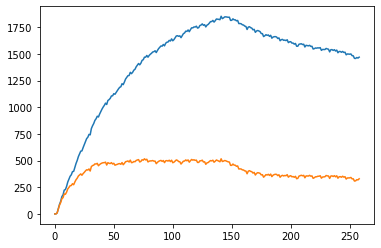

In [35]:
plt.plot(mle_results.filtered_state[0, :])
plt.plot(mle_results.filtered_state[1, :])

In [ ]:


As mentioned, there are recursive updating equations for the Kalman Filter that provide:

1. The likelihood of the observed data each time point given current and past observations
2. The 1-step ahead state-space prediction
3. The "fused" estimate of the state-space prediction and the measurement


are complicated (more complicated than linear regression, at least) but straightforward